In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import time
from utils import _get_clip_lengths, _get_parcel
from cc_utils import _get_clip_labels
from plot_utils import (_plot_hcp_style,
    _plot_ts, _get_ts, _plot_symmetric_ts)
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

# plot
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()
pio.templates.default = 'plotly_white'

import hcp_utils as hcp # hcp mesh, bgmap, etc
from nilearn import plotting

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Parameters

In [2]:
class ARGS():
    roi = 300
    net = 7
    subnet = 'wb'
    zscore = 1
    k_fold = 10

    batch_size = 32
    num_epochs = 45
    train_size = 100
    
    roi_name = "roi"
    
    #gru
    k_hidden = 32
    k_layers = 1
    k_dim = 3

In [3]:
args = ARGS()
K_RUNS = 4
K_SEED = 330

## Load results
Results used here are generated by the following files:
- saliency_clip.py

For architecture, see corresponding files.

In [4]:
def _get_results(RES_DIR, args):
    
    load_path = (RES_DIR + 
            '/%s_%d_net_%d' %(args.roi_name, args.roi, args.net) +
            '_trainsize_%d' %(args.train_size) +
            '_k_hidden_%d' %(args.k_hidden) +
            '_k_layers_%d_batch_size_%d' %(args.k_layers, args.batch_size) +
            '_num_epochs_%d_z_%d.pkl' %(args.num_epochs, args.zscore))

    with open(load_path, 'rb') as f:
        sal_df = pickle.load(f)
    
    return sal_df

In [5]:
RES_DIR = 'results/clip_saliency'
df = _get_results(RES_DIR, args)
# print('Test accuracy for low dim model = %0.3f' %np.mean(r['test']))
subject_list = df['Subject'].unique()
train_list = subject_list[:args.train_size]
test_list = subject_list[args.train_size:]

_, nw_info = _get_parcel(args.roi, args.net)

In [6]:
def _df_to_mat(df, test_list):
    '''
    gather saliency maps of all participants
    
    input:
    df: dataframe containing saliency maps
    test_list: list of participants in test data
    
    output:
    mat: dict of matrices for each clip
         matrix: (participants x len_seq x feat)
    '''
    k_class = len(np.unique(df['y']))
    grads = [ii for ii in df.columns if 'grad' in ii]
    k_feat = len(grads)
    
    # get clip timing
    subject = test_list[0]
    k_time = {}
    for i_class in range(k_class):
        seq = df[(df['Subject']==subject) & 
            (df['y'] == i_class)][grads].values
        if i_class==0:
            k_time[i_class] = int(seq.shape[0]/K_RUNS)
        else:
            k_time[i_class] = seq.shape[0]
      
    # gather saliency maps for {clip x participant}
    mat = {}
    for i_class in range(k_class):
        len_seq = k_time[i_class]
        
        if i_class==0:
            ts_3d = np.zeros((K_RUNS*len(test_list), 
                len_seq, k_feat))
            for jj, subject in enumerate(test_list):
                seqs = df[(df['Subject']==subject) & 
                    (df['y'] == 0)][grads].values
                for i_run in range(K_RUNS):
                    seq = seqs[i_run*len_seq:(i_run+1)*len_seq, :]
                    ts_3d[jj*K_RUNS + i_run, :, :] = seq
                    
        else:
            ts_3d = np.zeros((len(test_list), len_seq, k_feat))
            for jj, subject in enumerate(test_list):
                seq = df[(df['Subject']==subject) & 
                    (df['y'] == i_class)][grads].values
                ts_3d[jj, :, :] = seq
                
        mat[i_class] = ts_3d
        
    return mat

In [7]:
mat = _df_to_mat(df, test_list)

## Saliency visualized on a brain map

In [8]:
def _plot_nw_lines(nw_info, k_time):   
    # process nw_info
    networks, counts = np.unique(nw_info, return_counts=True)
    cumcounts = np.cumsum(counts)
    
    # separate networks
    plotter = {}
    for y in cumcounts:
        plotter[y] = go.Scatter(x=[-0.5, k_time+0.5],
        y=[y+0.5, y+0.5], mode='lines',
        line=dict(color=colors[9], width=1),
        showlegend=False)
        
    return plotter

def _compute_norm(ts_3d, norm_mode):
    '''
    ts_3d: size (participants x len_seq x feat)
    
    norm_mode:
        'zscore': normalize entire saliency map
        'scale': scale entire saliency map
        'normcol': scale each time step separately
    '''
    k_sub = len(ts_3d)
    k_len = ts_3d.shape[1]
    ts_3d_norm = np.zeros(ts_3d.shape)
    for ii in range(k_sub):
        if norm_mode=='zscore':
            ts_3d_norm[ii] = (ts_3d[ii] - np.mean(ts_3d[ii]))/np.std(ts_3d[ii])
        elif norm_mode=='zscorecol':
            for jj in range(k_len):
                ts_3d_norm[ii, jj] = (ts_3d[ii, jj] - np.mean(ts_3d[ii, jj]))/np.std(ts_3d[ii, jj])
        elif norm_mode=='scale':
            ts_3d_norm[ii] = ts_3d[ii]/np.max(ts_3d[ii])
        elif norm_mode=='normcol':
            ts_3d_norm[ii] = (ts_3d[ii].T/np.max(ts_3d[ii], axis=1).T).T
        
    return ts_3d_norm

def _compute_view(sal_map, view_mode):
    '''
    sal_map: size (roi x t)
    
    view_mode:
        'zscore': normalize entire saliency map
        'scale': scale entire saliency map
        'normcol': scale each time step separately
    '''
    if view_mode=='normcol':
        # scale each time step
        sal_map = (sal_map/np.max(sal_map, axis=0))
    elif view_mode=='zscore':
        # normalize entire saliency map
        sal_map = (sal_map - np.mean(sal_map))/np.std(sal_map)
    elif view_mode=='scale':
        # scale entire saliency map
        sal_map = sal_map/np.max(sal_map)
        
    return sal_map

def _compute_participant_average(ts_3d, mean_mode,
    sal_thresh=0.5, group_thresh=0.5):
    '''
    input:
    ts_3d: (participants x len_seq x feat)
    mean_mode:
        vanilla:
        median:
        std:
        bystd:
        thresh: threshold entries in saliency map based on
            how consistently they appear across participants
    dim = {0: across particpants,
        2: across ROIs within subnetworks}
    
    output:
    sal_map: (roi x t) if dim=0
    sal_map: (nw x participants x t) if dim=2
    '''
    if mean_mode=='vanilla':
        sal_map = np.mean(ts_3d, axis=0).T # roi x t
    elif mean_mode=='median':
        sal_map = np.median(ts_3d, axis=0).T # roi x t
    elif mean_mode=='bystd':
        ts_m = np.mean(ts_3d, axis=0)
        ts_s = np.std(ts_3d, axis=0)
        ts_c = (ts_m/ts_s)
        sal_map = ts_c.T # roi x t
    elif mean_mode=='thresh':
        # 
        bool_3d = np.zeros(ts_3d.shape).astype(bool)
        k_sub = ts_3d.shape[0]
        for jj in range(k_sub):
            ts_2d = np.abs(ts_3d[jj])

            # normalize participant map
            ts_2d = (ts_2d - np.mean(ts_2d))/np.std(ts_2d)

            # does participant entry exceed threshold?
            bool_3d[jj] = (ts_2d > sal_thresh)

        bool_sum = np.sum(bool_3d, axis=0)
        # does sum across particpants exceed group threshold?
        bool_map = (bool_sum > group_thresh*k_sub).T # roi x t

        # mask saliency map
        sal_map = np.mean(ts_3d, axis=0).T # roi x t
        sal_map[np.invert(bool_map)] = 0
                                    
    return sal_map

def _compute_nw_average(ts_3d, mean_mode,
    sal_thresh=0.5, group_thresh=0.5):

    sorted_nw_info = np.sort(nw_info) # roi_ts was sorted
    nws = np.unique(sorted_nw_info)
    sal_map = np.zeros((len(nws), ts_3d.shape[0], ts_3d.shape[1]))

    if mean_mode!='thresh':
        for jj, nw in enumerate(nws):
            idx = (sorted_nw_info==nw)
            ts_nw = ts_3d[:, :, idx]
            if mean_mode=='vanilla':
                sal_map[jj] = np.mean(ts_nw, axis=2) # k_sub x t
            elif mean_mode=='median':
                sal_map[jj] = np.median(ts_nw, axis=2) # k_sub x t
            elif mean_mode=='bystd':
                ts_m = np.mean(ts_nw, axis=2)
                ts_s = np.std(ts_nw, axis=2)
                ts_c = (ts_m/ts_s)
                sal_map[jj] = ts_c # k_sub x t
    elif mean_mode=='thresh':
        bool_3d = np.zeros(ts_3d.shape).astype(bool)
        k_sub = ts_3d.shape[0]
        for jj in range(k_sub):
            ts_2d = np.abs(ts_3d[jj])

            # normalize participant map
            ts_2d = (ts_2d - np.mean(ts_2d))/np.std(ts_2d)

            # does participant entry exceed threshold?
            bool_3d[jj] = (ts_2d > sal_thresh)

        bool_sum = np.sum(bool_3d, axis=0)
        # does sum across particpants exceed group threshold?
        bool_map = (bool_sum > group_thresh*k_sub) # t x roi

        # mask saliency map
        for jj in range(k_sub):
            # mask and insert each participant map
            ts_2d = ts_3d[jj]
            ts_2d[np.invert(bool_map)] = 0
            ts_3d[jj] = ts_2d

        for jj, nw in enumerate(nws):
            idx = (sorted_nw_info==nw)
            ts_nw = ts_3d[:, :, idx]
            if mean_mode=='vanilla':
                sal_map[jj] = np.mean(ts_nw, axis=2) # k_sub x t

    return sal_map
                


In [66]:
def _thresh_ROI(x, count):
    '''
    input x: ROI stat map [or t x ROI statmap]
    count: number of ROIs to retain
    '''
    s = np.sort(x.ravel())
    # set all entries but count to 0
    x[x<s[-count]] = 0
    
    return x

def _roi_to_voxel(x):
    '''
    input x: number of ROI
    output z: number of grayordinates
    '''
    parcel, nw_info = _get_parcel(args.roi, args.net)
    
    # undo sort x
    # https://stackoverflow.com/a/2497565
    y = x[np.argsort(np.argsort(nw_info))]
    
    z = np.zeros(parcel.shape)
    print(parcel.shape)
    for ii in range(1, args.roi + 1):
        z[parcel==ii] = y[ii-1] #y[0] is ROI 1
        
    return z

In [67]:
# def _windowed_saliency(ts_3d, window_size=10,
#     thresh_count=30, norm_mode='zscore',
#     mean_mode='vanilla', view_mode='scale', normd = True):

#     ts_3d = _compute_norm(ts_3d, norm_mode='zscore') # normalize each participant
#     sal_map = _compute_participant_average(ts_3d, mean_mode='vanilla') # average across participants
#     view_map = np.abs(_compute_view(sal_map, view_mode='scale')) # roi x t
#     len_seq = view_map.shape[1]
    
    
# #     sal_map_nw = _compute_nw_average(ts_3d, mean_mode='vanilla',
# #         sal_thresh=0.5, group_thresh=0.5)
# #     sal_map_nw = np.abs(_compute_view(sal_map_nw, view_mode='scale'))
# #     print("sal map nw shape is {}".format(sal_map_nw.shape))
    
#     abs_scaled_sal_map = np.abs(_compute_view(ts_3d, view_mode='scale'))
#     ste_sal_map = np.std(abs_scaled_sal_map, axis=0).T / np.sqrt(abs_scaled_sal_map.shape[0])
#     print(ste_sal_map.shape)
# #     print(abs_scaled_sal_map.shape)
    
#     # additional functions
#     normalize = lambda a: (a - np.mean(a)) / np.std(a)
    
# #     sorted_nw_info = np.sort(nw_info) # roi_ts was sorted
# #     nws = np.unique(sorted_nw_info)
    
# #     ste_ts = np.zeros((7, sal_map.shape[1]))
    
# #     for jj, nw in enumerate(nws):
        
# #         sal_nw = sal_map_nw[jj, :, :]
# #         ste_ts[jj, :] = _get_ts(sal_nw, dim=0, mult=1)['ste']
    
#     # get thresholded map for each window
#     window_map = np.zeros(view_map.shape)
# #     ste_window_map = np.zeros((7, window_map.shape[1]))
#     ste_window_map = np.zeros(view_map.shape)
#     for ii in range(len_seq):
#         start = ii
#         end = min(ii+window_size, len_seq)
#         if normd is True:
#             window = normalize(view_map[:, start:end])
#         else:
#             window = view_map[:, start:end]
        
        
#         # average across time (example)
#         snapshot = np.mean(window, axis=1)
#         thresh_map = _thresh_ROI(snapshot, thresh_count)

#         window_map[:, ii] = thresh_map
#         ste_window_map[:, ii] = np.mean(ste_sal_map[:, start:end], axis=1)

#     return window_map, ste_window_map

In [68]:
def _windowed_saliency(sal_3d, window_size=10, thresh_count=30, norm_mode='zscore',
    mean_mode='vanilla', view_mode='scale', normd = True):
    
    num_samples, num_times, num_rois = sal_3d.shape
    sorted_nw_info = np.sort(nw_info) # roi_ts was sorted
    nws = np.unique(sorted_nw_info)
    
    def aggregate_nw(ts_roi):
        '''
        Aggregate ROI timeseries into networks
        input : ts : #times x #ROIs
        output : ts_nw : #times x #networks
        '''
        ts_nw = np.zeros((ts_roi.shape[0], len(nws)))
        for idx_nw, nw in enumerate(nws):
            idx = (sorted_nw_info==nw)
            ts_roi_in_nw = ts_roi[:, idx]
            ts_nw[:, idx_nw] = np.mean(ts_roi_in_nw, axis=1)
        return ts_nw
    
    def _zscore_ts(ts):
        '''
        zscore each ROIs time series
        ts: (time x roi)
        '''
        ts = ts.T
        z_ts = []
        for ii in range(ts.shape[0]):
            t = ts[ii, :]
            z_ts.append((t - np.mean(t))/np.std(t))

        z_ts = np.array(z_ts)
        z_ts = z_ts.T

        return z_ts
    
    normalize = lambda a: (a - np.mean(a)) / np.std(a)
    
    '''
    START
    '''
    # aggregate ROIs into networks
    # makes sense to aggregate non-zscored values first
#     sal_nw_3d = np.zeros((sal_3d.shape[0], sal_3d.shape[1], len(nws)))
#     for idx_sample in range(num_samples):
#         sal_nw_3d[idx_sample, :, :] = aggregate_nw(sal_3d[idx_sample, :, :])
    
    # z-score every time series individually, for each participant and ROI.
    for idx_sample in range(num_samples):
        sal_3d[idx_sample, :, :] = normalize(sal_3d[idx_sample, :, :])#_zscore_ts(sal_nw_3d[idx_sample, :, :])#
    
    # take absolute value for all elements
    sal_3d = np.abs(sal_3d)
    
    # average across participants
    sal_avg = np.mean(sal_3d, axis=0)
    sal_ste = np.std(sal_3d, axis=0) / np.sqrt(num_samples)
    
    # need to plot 95% CI = 1.96 * STE not simply STE
    sal_ci95 = 1.96 * sal_ste

    for t in range(sal_avg.shape[0]):
        sal_avg[t, :] = _thresh_ROI(sal_avg[t, :], thresh_count)
    
    return sal_avg.T, sal_ci95.T

In [70]:
# original saliency
parcel, nw_info = _get_parcel(args.roi, args.net)
i_class = 14
ts_3d = mat[i_class]
window_map, ste_window_map = _windowed_saliency(ts_3d, window_size=10,
        thresh_count=30, norm_mode='zscore',
        mean_mode='vanilla', view_mode='scale', normd=False)
time_point = 7
roi_stat_map = window_map[:, time_point]
roi_ste_map = ste_window_map[:, time_point]

print(roi_stat_map.shape)

roi_stat_map_unsorted = roi_stat_map[np.argsort(np.argsort(nw_info))]
roi_ste_map_unsorted = roi_ste_map[np.argsort(np.argsort(nw_info))]

all_idx = np.where(roi_stat_map_unsorted>0)[0]
print(all_idx)
# print(ste_window_map[all_idx, time_point])
print(np.max(roi_ste_map_unsorted[all_idx]), np.min(roi_ste_map_unsorted[all_idx]))
x = _roi_to_voxel(roi_stat_map)
print(x.shape)
threshold = np.min(x[x>0])
vmax = np.max(x[x>0])

(300,)
[  3   4   5   7   8  10  12  15  19  24  25  56  68  87 115 118 125 152
 153 155 156 159 161 162 168 173 174 177 179 246]
1.7829948025318587 0.6043404786585709
(59412,)
(59412,)


In [61]:

dark24 = px.colors.qualitative.Dark24
light24 = px.colors.qualitative.Light24
# colors = [light24[14], light24[1], light24[4], light24[5], light24[6], light24[13], dark24[5]]
colors= px.colors.qualitative.Plotly
nw_names = np.sort(np.unique(nw_info))
nw_colors = colors[:7]
nw_name_to_color = dict(zip(nw_names, nw_colors))
colors_list = np.array([nw_name_to_color[nw_info[i]] for i in range(args.roi)])
levels = np.arange(1, args.roi+1)
hemi = args.roi//2

left_idx = all_idx[all_idx < 150]
right_idx = all_idx[all_idx >= 150]

In [62]:
# plotting.plot_stat_map(stat_map_img=hcp.cortex_data(x, fill=0), display_mode='x', threshold=None,
#                        cut_coords=range(0, 51, 10), title='Slices')
print(len(hcp.cortex_data(x, fill=0)))

64984


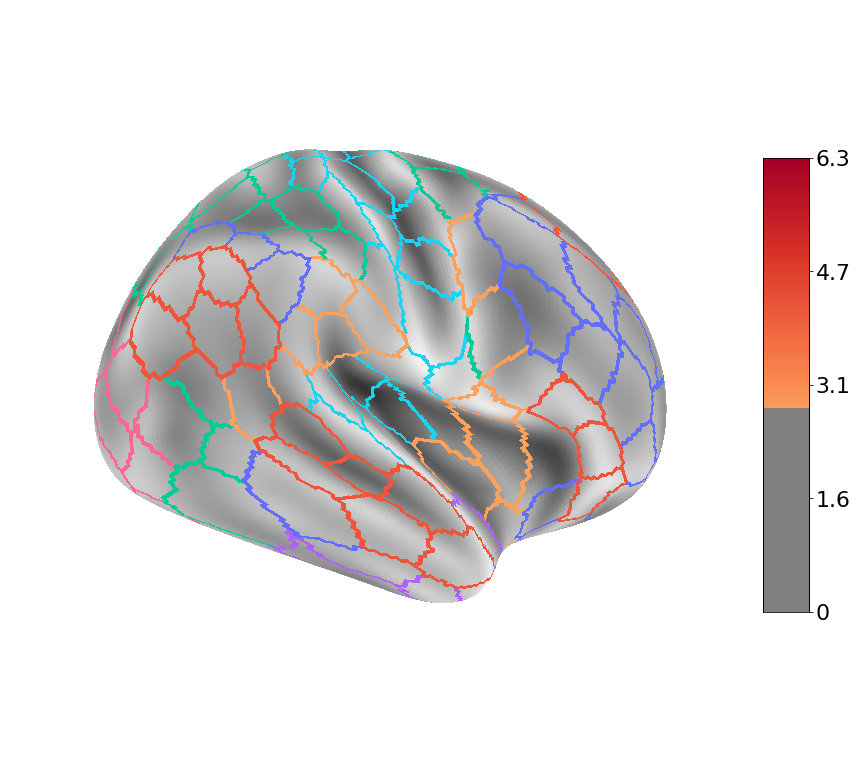

In [54]:
# right medial
figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x, fill=0), 
                                     surf_mesh=hcp.mesh.very_inflated_right, 
                                     bg_map=hcp.mesh.sulc_right, 
                                     vmax=vmax, cmap='RdYlBu_r', threshold=threshold, colorbar=True, 
                                     symmetric_cbar=False, view='medial', darkness=0.8)

plotting.plot_surf_contours(surf_mesh=hcp.mesh.very_inflated_right, roi_map=hcp.right_cortex_data(parcel, fill=0), 
                            labels=nw_info[right_idx],
                            levels=levels[right_idx], figure=figure, legend=False,
                            colors=colors_list[right_idx])
figure.set_size_inches(18.5, 10.5)
# figure.savefig('figures/saliency/t{}_right_medial.png'.format(time_point), dpi=300, bbox_inches='tight')
plotting.show()

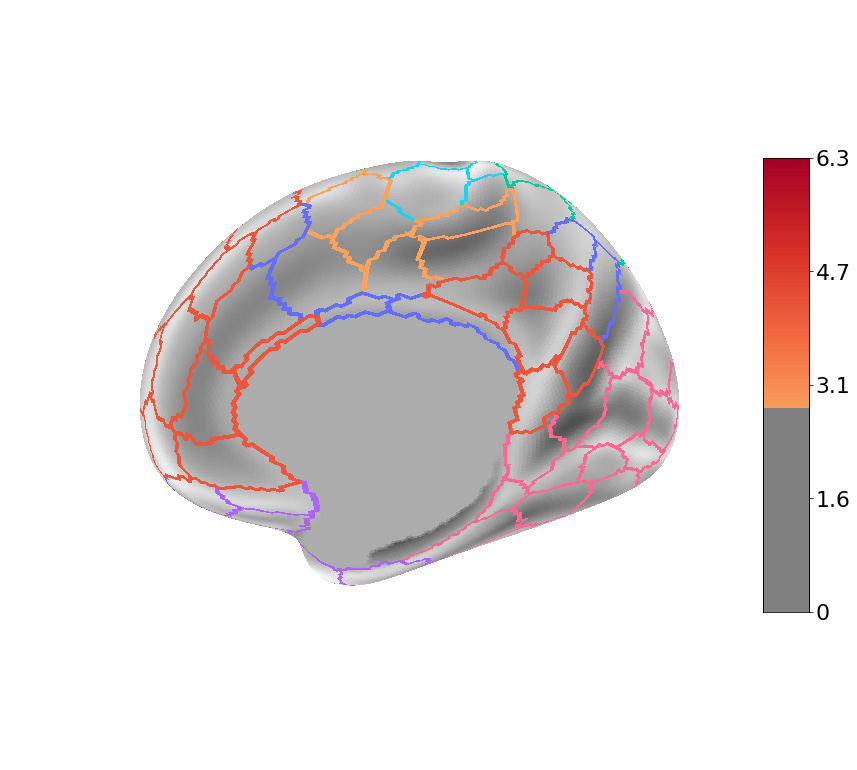

In [55]:
# right lateral
figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x, fill=0), 
                                     surf_mesh=hcp.mesh.very_inflated_right, 
                                     bg_map=hcp.mesh.sulc_right, 
                                     vmax=vmax, cmap='RdYlBu_r', threshold=threshold, colorbar=True, 
                                     symmetric_cbar=False, view='lateral', darkness=0.8)

plotting.plot_surf_contours(surf_mesh=hcp.mesh.very_inflated_right, roi_map=hcp.right_cortex_data(parcel, fill=0), 
                            labels=nw_info[right_idx],
                            levels=levels[right_idx], figure=figure, legend=False,
                            colors=colors_list[right_idx])
figure.set_size_inches(18.5, 10.5)
# figure.savefig('figures/saliency/t{}_right_lateral.png'.format(time_point), dpi=300, bbox_inches='tight')
plotting.show()

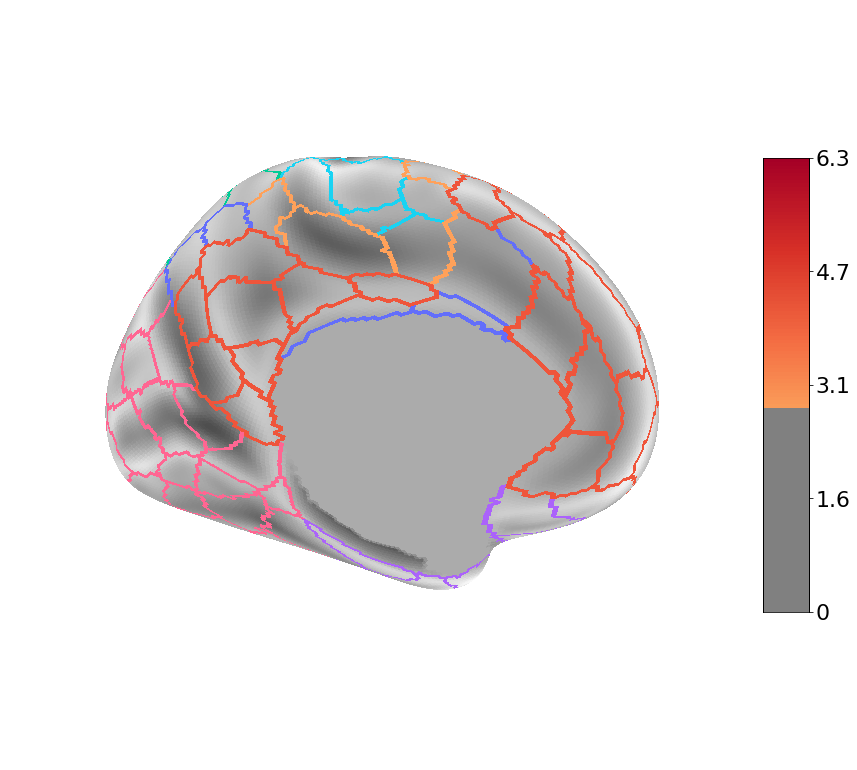

In [56]:
# left medial
figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x, fill=0), 
                                     surf_mesh=hcp.mesh.very_inflated_left, 
                                     bg_map=hcp.mesh.sulc_left, 
                                     vmax=vmax, cmap='RdYlBu_r', threshold=threshold, colorbar=True, 
                                     symmetric_cbar=False, view='medial', darkness=0.8)

plotting.plot_surf_contours(surf_mesh=hcp.mesh.very_inflated_left, roi_map=hcp.left_cortex_data(parcel, fill=0), 
                            labels=nw_info[left_idx],
                            levels=levels[left_idx], figure=figure, legend=False,
                            colors=colors_list[left_idx])

figure.set_size_inches(18.5, 10.5)
figure.savefig('figures/saliency/t{}_left_medial.png'.format(time_point), dpi=300, bbox_inches='tight')
plotting.show()

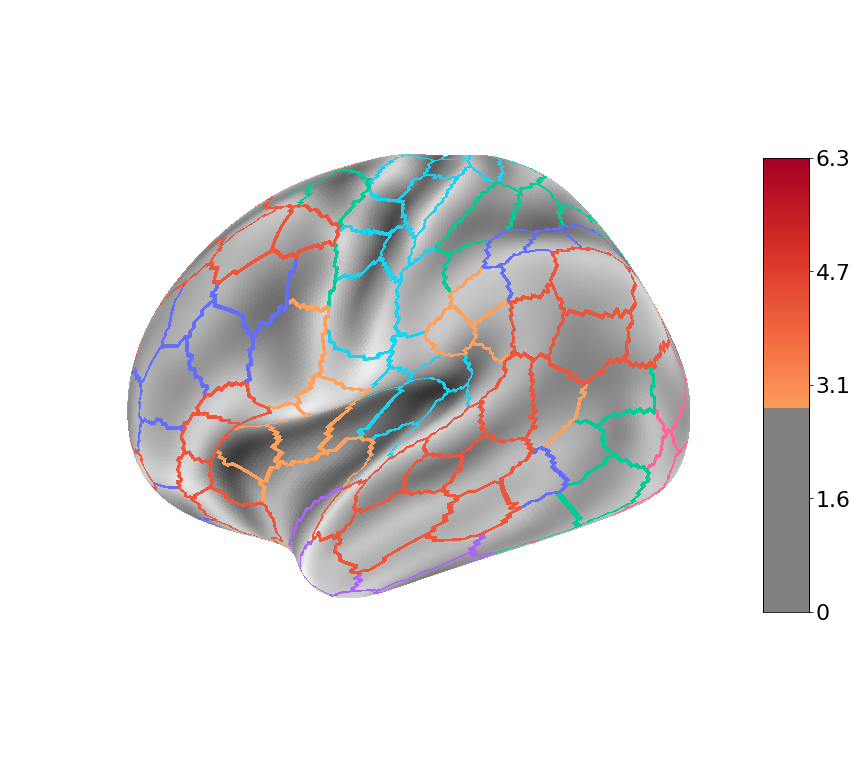

In [57]:
# left lateral
figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x, fill=0), 
                                     surf_mesh=hcp.mesh.very_inflated_left, 
                                     bg_map=hcp.mesh.sulc_left, 
                                     vmax=vmax, cmap='RdYlBu_r', threshold=threshold, colorbar=True, 
                                     symmetric_cbar=False, view='lateral', darkness=0.8)

plotting.plot_surf_contours(surf_mesh=hcp.mesh.very_inflated_left, roi_map=hcp.left_cortex_data(parcel, fill=0), 
                            labels=nw_info[left_idx],
                            levels=levels[left_idx], figure=figure, legend=False,
                            colors=colors_list[left_idx])
figure.set_size_inches(18.5, 10.5)
# figure.savefig('figures/saliency/t{}_left_lateral.png'.format(time_point), dpi=300, bbox_inches='tight')
plotting.show()

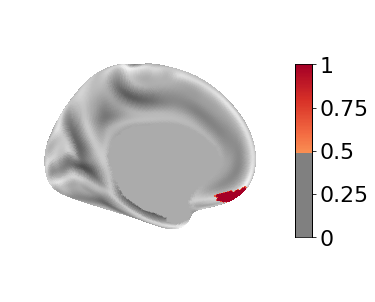

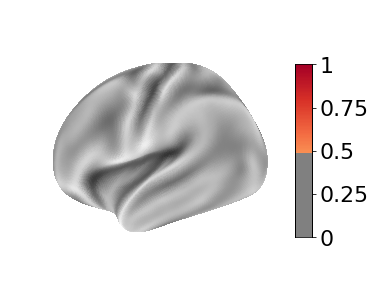

In [65]:
def locate_roi(idx_roi):
    roi_labels_map = np.zeros(roi_stat_map.shape)
#     roi_labels_map[all_idx[idx_roi]] = 1#counter
    roi_labels_map[idx_roi] = 1
#     print(all_idx[idx_roi])
    roi_labels_map = roi_labels_map[np.argsort(nw_info)]
    x_roi_labels_map = _roi_to_voxel(roi_labels_map)
    x = _roi_to_voxel(roi_stat_map)
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_left, 
#                                          bg_map=hcp.mesh.sulc_left, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='lateral', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
    figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x_roi_labels_map, fill=0), 
                                         surf_mesh=hcp.mesh.very_inflated_left, 
                                         bg_map=hcp.mesh.sulc_left, 
                                         vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
                                         symmetric_cbar=False, view='medial', darkness=0.8)
#     figure.set_size_inches(9, 5)
    plotting.show()
    figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x_roi_labels_map, fill=0), 
                                         surf_mesh=hcp.mesh.very_inflated_left, 
                                         bg_map=hcp.mesh.sulc_left, 
                                         vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
                                         symmetric_cbar=False, view='lateral', darkness=0.8)
#     figure.set_size_inches(9, 5)
    plotting.show()
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.left_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_left, 
#                                          bg_map=hcp.mesh.sulc_left, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='dorsal', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_right, 
#                                          bg_map=hcp.mesh.sulc_right, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='lateral', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_right, 
#                                          bg_map=hcp.mesh.sulc_right, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='medial', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_right, 
#                                          bg_map=hcp.mesh.sulc_right, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='ventral', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
#     figure = plotting.plot_surf_stat_map(stat_map=hcp.right_cortex_data(x_roi_labels_map, fill=0), 
#                                          surf_mesh=hcp.mesh.very_inflated_right, 
#                                          bg_map=hcp.mesh.sulc_right, 
#                                          vmax=1, cmap='RdYlBu_r', threshold=0.5, colorbar=True, 
#                                          symmetric_cbar=False, view='dorsal', darkness=0.8)
# #     figure.set_size_inches(9, 5)
#     plotting.show()
# for roi in all_idx[15:]:
#     print(roi)
locate_roi(87)

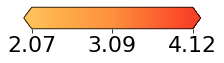

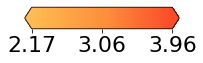

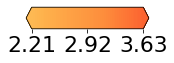

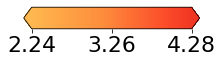

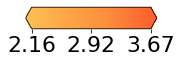

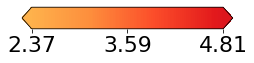

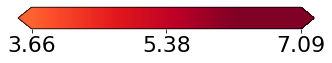

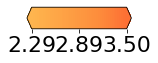

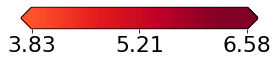

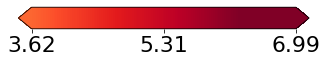

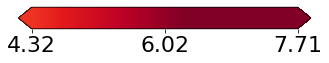

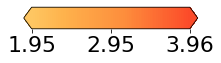

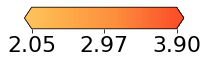

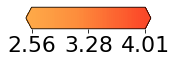

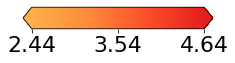

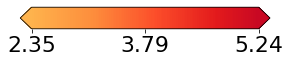

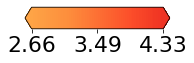

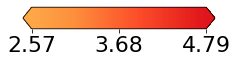

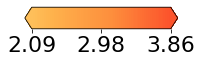

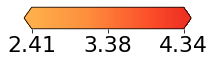

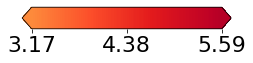

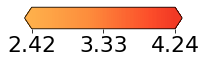

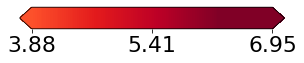

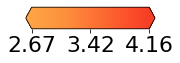

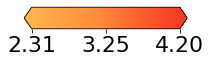

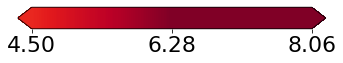

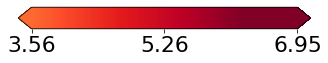

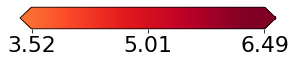

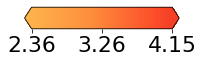

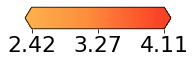

In [20]:
import pylab as pl
import matplotlib.colors as mcolors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def gen_errorbar(mean, ste, idx):
    l = mean - ste
    r = mean + ste

    minColor = l/vmax
    maxColor = r/vmax
    cmap_t = truncate_colormap(plt.get_cmap("YlOrRd"), minColor, maxColor)

    a = np.array([[l,r]])
    pl.figure(figsize=(3*ste, 0.5))
    img = pl.imshow(a, cmap=cmap_t)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.2, 0.8, 0.6])
    cbar = pl.colorbar(orientation="horizontal", cax=cax, extend='both')
    cax.vlines(mean, 0, 1, colors = 'w', linewidth = 5, linestyles = '-')
    cbar.set_ticks([mean-ste, mean, mean+ste])
    cax.set_xticklabels(["{0:.2f}".format(mean-ste), "{0:.2f}".format(mean), "{0:.2f}".format(mean+ste)])
    pl.savefig(f"figures/errbars/errbar_roi{idx}.png", dpi=300, bbox_inches='tight')

for idx_roi in all_idx:
    mean = roi_stat_map_unsorted[idx_roi]
    ste = roi_ste_map_unsorted[idx_roi]
    gen_errorbar(mean, ste, idx_roi)
# pl.savefig("colorbar.pdf")

In [ ]:
import numpy as np


gs = gridspec.GridSpec(2, 1,
                       height_ratios=[1, 4]
                       )
ax = [plt.subplot(g) for g in gs]

parameterToColorBy = np.linspace(5, 10, 6, dtype=float)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.00
maxColor = 0.85
inferno_t = truncate_colormap(plt.get_cmap("inferno"), minColor, maxColor)

colors = [inferno_t(i)
          for i in np.linspace(0, 1, parameterToColorBy.shape[0])]

norm = mpl.colors.Normalize(parameterToColorBy[0],
                            parameterToColorBy[-1])

cb = mpl.colorbar.ColorbarBase(ax[0],
                               cmap=inferno_t,
                               norm=norm,
                               ticks=parameterToColorBy,
                               orientation='horizontal')

ax[0].xaxis.set_ticks_position('top')

for p, c in zip(parameterToColorBy, colors):
    ax[1].plot(np.arange(2)/p, c=c)

plt.show()
